# HOMEWORK # 4 - Clustering Algorithms
### Well-Being Technologies
#### Authors: Garbarino Giacomo and Parmiggiani Manuel
#### Date: 31/05/2022

# Assignment: Develop Hard and Fuzzy Clustering Algorithms from scratch
We will implement some clustering algorithms from scratch and we will test on two data sets constituted by some 2-dimensional distributions of points and on the Iris dataset.



### TODO:
1. Generate data sets DS1 (non overlapping blobs), DS2 (overlapping blobs) and load DS3 from the file iris.csv.
2. Implement K-Means, Fuzzy C- Means and Graded Possibilistic C-Means.
3. Implement  WTA and the $\alpha - cut$ defuzzifiers of fuzzy partitions.
4. Implement RAND and Jaccard Indeces for hard partition comparison
5. Apply K-Means, Fuzzy C-Means and Graded Possibilistic C-Means to the 3 data sets using a multi-start approach; search for 2, 3, and 4 clusters.
6.  Defuzzify the soft partitions of  Fuzzy C- Means and Graded Possibilistic C-Means using the WTA (Winner-Takes-All) criterion.
7. Visualize the results on the scatter plot, highlighting the centroids and using a different color for each cluster.
8.  Measure the *accuracy* of the hard partitions by comparing them with the ground-truth constituted by the targets of the data sets. For the comparison use RAND and Jaccard indeces. 

For the Graded Possibilistic C-Means use a possibilistic degree $\beta=0.8$ and a value of $\eta$ (identical for each cluster) comparable with the *standard_dev*$^2$ for data sets DS1 and DS2. For DS3 (Iris data set)  $\eta$ must be selected by checking the value of the accuracy (model selection - grid search).


## Import libraries

In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

## Auxiliar functions

Function to convert the real datasets into membership matrices for accuracy measuring

In [2]:
def get_real_U(target, number_of_clusters):
    number_of_points = target.shape[0]
    real_U = np.zeros((number_of_points, number_of_clusters), dtype=int)
    for i in range(number_of_points):
        cluster = target[i]
        real_U[i, cluster] = 1
        
    return real_U

Real_U_List = list()

## 1 Data sets generation

### Data set DS1: Separate blobs

 * number of points in the dataset  400
 * number of features in the dataset  2
 * number of clusters in the dataset 3   
 * standard deviation of points of a cluster 0.70 

In [3]:
# Dataset setup
number_of_points = 400    # number of points in the dataset
number_of_features = 2    # number of features in the dataset
number_of_clusters = 3    # number of clusters in the dataset
standard_dev = 0.70       # standard deviation of points of a cluster

features, target = make_blobs(n_samples = number_of_points, 
                  n_features = number_of_features,
                  centers = number_of_clusters,
                  cluster_std = standard_dev,
                  shuffle = True)

Real_U_List.append(get_real_U(target, number_of_clusters))

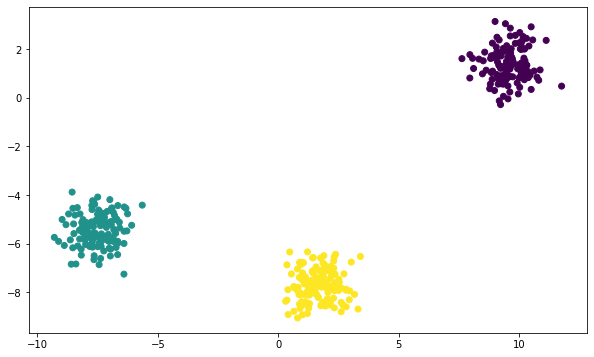

In [4]:
# Create a scatterplot of first two features
plt.figure(figsize=(10,6))
plt.scatter(features[:,0], features[:,1], c=target)

# View scatterplot
plt.show()

In [5]:
x_labels = ['Feature'+str(x) for x in range(features.shape[1])]
y_label = 'target'

feats = pd.DataFrame(features, columns=x_labels)
tgts = pd.Series(target, name=y_label)
dataset1 = pd.concat([feats,tgts],axis=1)
dataset1.head()

,Feature0,Feature1,target
0,1.078618,-7.649957,2
1,-8.178979,-6.466141,1
2,2.322510,-6.542664,2
3,-8.532610,-6.165853,1
4,-7.907117,-5.291613,1


### Data set DS2: Overlapping  blobs
 * number of points in the dataset  400
 * number of features in the dataset  2
 * number of clusters in the dataset 3   
 * standard deviation of points of a cluster 1.70 

In [6]:
# Dataset setup
number_of_points = 400    # number of points in the dataset
number_of_features = 2    # number of features in the dataset
number_of_clusters = 3    # number of clusters in the dataset
standard_dev = 1.70       # standard deviation of points of a cluster


features, target = make_blobs(n_samples = number_of_points, 
                  n_features = number_of_features,
                  centers = number_of_clusters,
                  cluster_std = standard_dev,
                  shuffle = True)

Real_U_List.append(get_real_U(target, number_of_clusters))

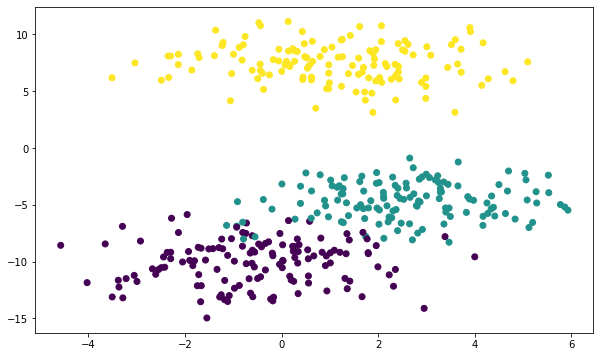

In [7]:
# Create a scatterplot of first two features
plt.figure(figsize=(10,6))
plt.scatter(features[:,0], features[:,1], c=target)

# View scatterplot
plt.show()

In [8]:
x_labels = ['Feature'+str(x) for x in range(features.shape[1])]
feats = pd.DataFrame(features, columns=x_labels)
tgts = pd.Series(target, name='target')
dataset2 = pd.concat([feats,tgts],axis=1)
dataset2.head()

,Feature0,Feature1,target
0,2.348136,7.360045,2
1,2.065425,9.362122,2
2,0.884706,8.654793,2
3,-2.548227,-10.697699,0
4,-0.035267,-7.530565,0


### Data set DS3: Iris Data set 

Read the data set from the file *iris.csv*.


In [9]:
col_names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class'] #nomi colonne
dataset = pd.read_csv('iris.csv', names=col_names)

targ = 'class'

x = dataset.get('petal-length')
y = dataset.get('petal-width')
oldName = dataset.get(targ)
newName = list()
for el in oldName:
    if el=='Iris-setosa':
        newName.append(0)
    if el=='Iris-versicolor':
        newName.append(1)
    if el=='Iris-virginica':
        newName.append(2)
 
targ = pd.Series(newName, name='target')

Real_U_List.append(get_real_U(targ, 3))

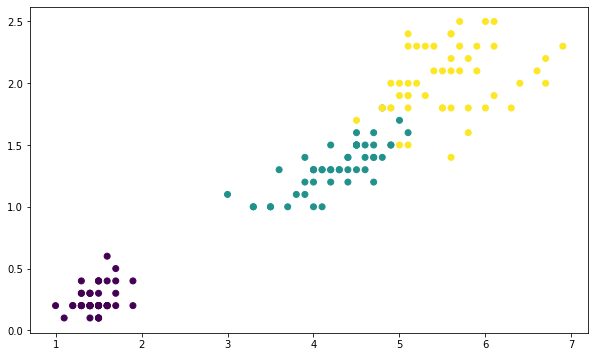

In [10]:
# Create a scatterplot of first two features
plt.figure(figsize=(10,6))
#plt.scatter(features[:,0], features[:,1], c=target)
plt.scatter(x,y,c=targ)

# View scatterplot
plt.show()

In [11]:
datasetIris = pd.concat([x,y,targ],axis=1)
datasetIris.columns = ['Feature0', 'Feature1', 'target']
datasetIris.head()

,Feature0,Feature1,target
0,1.4,0.2,0
1,1.4,0.2,0
2,1.3,0.2,0
3,1.5,0.2,0
4,1.4,0.2,0


## 2 Implentation of clustering algoritms 

### K-Means (aka Hard C-Means)
K-Means minimizes the functional 
 
 
 $$
  E(X) = \sum_{i=1}^{K}\sum_{{\bf x} \in \pi_i} \| {\bf x} - {\bf v}_i \|^2
=\sum_{ih} u_{ih}\| {\bf x}_{h} - {\bf v}_i \|^2,\; \;  \mbox{with}\; \; u_{ih}= \left \{ 
 \begin{array}{ll}    
          1 & if \; \boldsymbol{x}_{h} \in \pi_i \\
         0 & otherwise
        \end{array}\right. $$
        
 
 where $\bf x$ is a point of the data set, $n$ is the size of the data set, $K$ is the number of clusters,  ${\bf v}_i$ are the centroids, and
 $\pi_i$ is the subset of the data set belonging to cluster $i$. Note that $E(X)$ is proportional to the expectation of distortion.
 
In this implementation we will initialize the cluster centers by selecting at random  K  points from the data set, and  then we will iterate the re-evaluation of all $\pi_i$ and of ${\bf v}_i$, until a STOP CRITERION holds.
 
The STOP CRITERION can be:

1. *Stop when the variation of $E(X)$ in two subsequent cycles ($\Delta E$) is under an assigned threshold $\tau > 0$*.
2. *Stop when the maximum variation of the centroids ${\bf v}_i$  in two subsequent cycles ($\Delta {\bf v}$) is under an assigned threshold $\tau > 0$*.
3. *Stop after an assigned value $S$ of iterations*.

We suggest to use the following combined STOP CRITERION:  **Stop after an assigned value $S$ of iterations** AND **Stop when the variation of $<E> =\frac{E(X)}{K \cdot n}$ in two subsequent cycles ($\Delta <E>$) is under an assigned threshold $\tau > 0$**.

In [12]:
# add here the required imports
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d #for voronoi tessellation

In [13]:
class KMeans:

    def __init__(self, k=3, tau=0.001, max_iter=300, verbose=False):
        self.k = k # number of centroids
        self.tau = tau # stopping threshold
        self.max_iter = max_iter # maximum number of iterations in case of no convergence
        self.verbose = verbose # detailed printout
        self.cost = list() # service variable to store cost history
        self.centroids = None # centroids after fitting
        self.U = None # membership matrix (for K-Means U is hard, i.e. its element are 0/1)

        # additional variable shared among the various functions
        self.n = 0 # holds the dataset size
        self.prev_error = np.inf # assign initial error as infinite
        self.iteration = None # interation number
        self.error =  None # private variable to hold error E(X)
        self.distances = None # private variable to hold distances
        self.prev_centroids = None
        self.x_map = None
               
    def get_centroids(self):
        return self.centroids
    
    def get_U(self):
        return self.U
    
    def get_cost_history(self):
        return self.cost
    
    def plot_cost_history(self, size_x = 15, size_y = 6, data=None, label=None):
        if data==None:
            data= self.cost
        if label==None:
            label = 'Cost History'
            
        # simply plot the cost history
        fig, ax = plt.subplots(figsize=(size_x,size_y))

        ax.plot(data, color='r', label=label)     # cost line
        ax.legend()
        plt.show()
        return ax

    def calc_cost(self):
        # reset distances for items for farther clusters
        # define the cluster index list for data items
        x_map = np.argmin(self.distances,axis=1)
        # define the membership matrix from cluster index list
        # u becomes 1 for items in given cluster and zero for the others
        u = np.zeros_like(self.distances)
        u[np.arange(self.n),x_map] = 1
        # set the distances other than minimal to zero
        dist = np.multiply(self.distances,u)
        if self.verbose: sys.stderr.write('dist: {}\n'.format(dist))
        # compute the error - <E> expectation of distortion
       
        self.error = np.sum(dist)/(self.k*self.n)
        #self.error = np.sum(dist)
       
        #delta_e = np.abs(self.prev_error - error)
        delta_e = self.prev_error - self.error
        #print ("error= ", error, " delta_error= ", delta_e)
        self.cost.append(self.error)
        self.prev_error = self.error
        return delta_e

    def predict(self,x):
        # checks the test samples and return the list of centroid indexes 
        # which each sample belongs to

        if self.verbose: sys.stderr.write('centroids: {}\n'.format(self.centroids))

        # compute distances from centroids
        for j in range(self.n):
            for i in range(self.k):
                #self.distances[j][i] = np.sqrt(np.sum((x[j]-self.centroids[i])**2))
                #self.distances[j][i] = np.sum((x[j]-self.centroids[i])**2)
                self.distances[j][i] = np.sum(np.dot(x[j]-self.centroids[i],x[j]-self.centroids[i]))
                # Here we sort the distances of an instance from  all centroids using the squared 
                # Euclidean distance, as the square root is a monotone function. 
                
                
        #print (self.distances)
        # assign the points of the data sets to the k clusters (nearest centroid)
        self.x_map = np.argmin(self.distances,axis=1)
        return self.x_map

    def get_centroids_distance(self):
        clu_dist = 0
        for c, pc in zip(self.centroids,self.prev_centroids): clu_dist += np.sqrt(np.dot(c-pc,c-pc))
        return clu_dist
    
    def fit (self, x):
        # performs kmeans clustering on training samples and assign centroids
        self.n = x.shape[0]  # number of training items
        c = x.shape[1]  # number of features 

        # initialize the K centroids by selecting at random  K  points from the data_set
        idx = np.random.randint(self.n,size=self.k)
        self.centroids = x[idx].copy()
        self.prev_centroids = self.centroids.copy()

        # initialize the membership matrix with n rows and k columns
        self.U = np.zeros((self.n,self.k), dtype=int)
        # create a distance matrix with the same shape as the membership one
        self.distances = np.zeros_like(self.U,dtype=float)

        # iterate while DELTA E > tau (STOP CRITERION #1) or max_iter not reached
        loop = True
        self.iteration = 0
        while (loop):
            # match training data to the current centroids and update their
            # membership index list
            self.x_map = self.predict(x)
            if self.verbose: sys.stderr.write('x_map: {}\n'.format(self.x_map))

            # calculate the new k centroids
            for i in range(self.k):
                # perform the average only if the centroid has assigned elements
                # otherwise NaN is assigned and the algorithm has errors
                if (self.x_map == i).any(): 
                    self.centroids[i] = np.average(x[self.x_map == i],axis=0)

            delta_cost = self.calc_cost()
            self.iteration +=1 
            # break the loop if the stopping conditions are met
            clu_dist = self.get_centroids_distance()
            self.prev_centroids = self.centroids.copy()
            if self.verbose:
                  print(self.iteration, "error= ", self.error, " delta_error= ", delta_cost, "tau = ", self.tau)
            loop = (abs(delta_cost) > self.tau) and (self.iteration < self.max_iter)

            #loop = (delta_cost > self.tau) and (clu_dist > self.tau) and (self.iteration < self.max_iter)

        # set the membership matrix for the final configuration 
        self.U[np.arange(self.n),self.x_map] = 1

        return self
    

### Fuzzy C-Means

Fuzzy C-Means minimizes the functional

  $$J(U, V) = \sum_{h=1}^{n}\sum_{i=1}^{c} \left( u_{ih} \right)^m \| \mathbf{x}_h - \mathbf{v}_i \|^2 \;, \qquad \forall h=1, \ldots, n\qquad \forall i=1, \ldots, c$$


  
 with the  probabilistic constraint

  $$\sum_{i=1}^{c} u_{ih} = 1 $$
  
  where ${\bf x}_h$ are the point of the data set, $c$ is the number of clusters,  ${\bf v}_i$ are the centroids, and
  $u_{ih}$ are the membrships of data points to clusters.
 
 
In this implementation we will initialize the cluster centers ${\bf v}_i$ by selecting at random  $c$  points from the data set, and  then we will iterate the re-evaluation of all $u_{ih}$ and of $\bf {v}_i$,

 $$ u_{ih} = \frac{1}{\sum_{j=1}^{c}
    \left( \frac{\| \mathbf{x}_h - \mathbf{v}_i \|}{\|\mathbf{x}_h - \mathbf{v}_j\|} \right)^{\frac{2}{m-1}} }$$

 
$$ \mathbf{v}_i = \frac{\sum_{h=1}^{n} \left( u_{ih} \right)^m \mathbf{x}_h}
         {\sum_{h=1}^{n} \left( u_{ih} \right)^m}$$

 
until a STOP CRITERION holds.
 
The STOP CRITERION can be either: 
1. *Stop when the variation of $J(U, V)$ in two subseguent cycles ($\Delta J$) is under an assigned threshold $\tau > 0$*.
2. *Stop when the variation of $$ E(X) =\sum_{ih} u_{ih}\| {\bf x}_{h} - {\bf v}_i \|^2 $$ 
in two subseguent cycles ($\Delta E$) is under an assigned threshold $\tau >0 $*.
3. *Stop when the maximum variation of the centroids ${\bf v}_i$ in  two subseguent cycles ($\Delta {\bf v}$) is under an assigned threshold $\tau \ge 0$*.
4. *Stop when the maximum variation of the memberships  $u_{ih}$ in two subseguent cycles ($\Delta u$) is under an assigned threshold $\tau \ge 0$*.
5. Stop after an assigned value $S$ of iterations.



We suggest to use the following combined STOP CRITERION:  **Stop after an assigned value $S$ of iterations** AND **Stop when the variation of $<E> =\frac{E(X)}{c\cdot n}$ in two subseguent cycles ($\Delta <E>$) is under an assigned threshold $\tau > 0$**.


In [14]:
class CMeans:

    def __init__(self, k=3, m=2, tau=0.001, max_iter=300, verbose=False):
        self.k = k # number of centroids
        self.tau = tau # stopping threshold
        self.max_iter = max_iter # maximum number of iterations in case of no convergence
        self.verbose = verbose # detailed printout
        self.cost = list() # service variable to store cost history
        self.delta_e_hist = list() # service variable to store delta_e history 
        self.centroids = None # centroids after fitting
        self.U = None # membership matrix (for K-Means U is hard, i.e. its element are 0/1)
        self.m = m #fuziness parameter
        
        # additional variable shared among the various functions
        self.n = 0 # holds the dataset size
        self.prev_error = np.inf # assign initial error as infinite
        self.iteration = None # interation number
        self.error =  None # private variable to hold error E(X)
        self.distances = None # private variable to hold distances
        self.prev_centroids = None
        self.x_map = None
               
    def get_centroids(self):
        return self.centroids
    
    def get_U(self):
        return self.U
    
    def get_cost_history(self):
        return self.cost
    
    def plot_cost_history(self, size_x = 15, size_y = 6, data=None, label=None):
        if data==None:
            data= self.cost
        if label==None:
            label = 'Cost History'
            
        # simply plot the cost history
        fig, ax = plt.subplots(figsize=(size_x,size_y))

        ax.plot(data, color='r', label=label)     # cost line
        ax.legend()
        plt.show()
        return ax

    def calc_cost(self):
        # iterate over the distances and multiply with membership
        dist = np.multiply(self.distances,self.U) 
        if self.verbose: sys.stderr.write('dist: {}\n'.format(dist))
        
        # compute the error - <E> expectation of distortion
        self.error = np.sum(dist)/(self.k*self.n)
        self.cost.append(self.error)
            
        # compute the variation of error
        delta_e = self.prev_error - self.error
        self.delta_e_hist.append(delta_e)
       
        # store current error in prev_error to use it in next iteration
        self.prev_error = self.error
        return delta_e

    def predict(self,x):
        # compute distances from centroids
        for j in range(self.n):
            for i in range(self.k):
                self.distances[j][i] = np.linalg.norm(x[j]-self.centroids[i], 2)**2  
                #self.distances[j][i] = np.sum(np.dot(x[j]-self.centroids[i],x[j]-self.centroids[i]))
                #self.x_map[j][i] = (self.U[j][i]**self.m) * self.distances[j][i]
                
        self.x_map = np.argmin(self.distances,axis=1)
        return self.x_map
    
    #def euclid_distance(P1, P2):
        #dist = np.sum(np.dot(P1-P2,P1-P2))
        #dist = np.linalg.norm(P1-P2,2)**2
        #return dist
    
    def get_fuzzy_memberships(self, x):
        for h in range(self.n):
            for i in range(self.k):
                sum = 0
                for j in range(self.k):
                    if (x[h] == self.centroids[j]).all(): # data point is equal to centroid point, handle dividing by zero
                        val = np.inf
                    else:
                        val = np.linalg.norm(x[h]-self.centroids[i]) / np.linalg.norm(x[h]-self.centroids[j])
                        val = val**(2/(self.m-1))
                    sum += val
                self.U[h][i] = 1/sum
        return self.U
        
    def fit (self, x):
        self.n = x.shape[0]  # number of training items
        c = x.shape[1]  # number of features 

        # initialize the K centroids by selecting at random  K  points from the data_set
        idx = np.random.randint(self.n,size=self.k)
        self.centroids = x[idx].copy()
        self.prev_centroids = self.centroids.copy()

        # initialize the membership matrix with n rows and k columns
        self.U = np.zeros((self.n,self.k), dtype=float) #the type of U is now float instead of integer
        # create a distance matrix with the same shape as the membership one
        self.distances = np.zeros_like(self.U,dtype=float)

        # iterate while DELTA E > tau (STOP CRITERION #1) or max_iter not reached
        loop = True
        self.iteration = 0
        while (loop):
            # match training data to the current centroids and update their
            # membership index list
            self.x_map = self.predict(x)
            if self.verbose: sys.stderr.write('self.distances: {}\n'.format(self.distances))
            if self.verbose: sys.stderr.write('self.x_map: {}\n'.format(self.x_map))
            
            # compute the fuzzy membership Uih of the data points to each cluster
            self.U = self.get_fuzzy_memberships(x)
            if self.verbose: sys.stderr.write('self.U: {}\n'.format(self.U))
            
            # calculate the new k centroids
            for i in range(self.k):
                sumNum = 0
                sumDenom = 0
                for h in range(self.n):
                    sumNum += (self.U[h][i]**self.m) * x[h]
                    sumDenom += self.U[h][i]**self.m
                self.centroids[i] = sumNum / sumDenom

            delta_cost = self.calc_cost()
            self.iteration +=1 
            # break the loop if the stopping conditions are met
            self.prev_centroids = self.centroids.copy()
            if self.verbose:
                  print(self.iteration, "error= ", self.error, " delta_error= ", delta_cost, "tau = ", self.tau)
            loop = (abs(delta_cost) > self.tau) and (self.iteration < self.max_iter)
            
        return self

### Graded Possibilistic C-Means (GPCM)

Graded Possibilistic C-Means (GPCM)


 
 In this implementation we will initialize the cluster centers ${\bf v}_i$ by selecting at random  $c$  points from the data set, and  then we will iterate the re-evaluation of all $u_{ih}$ and of $\bf {v}_i$,
 
$$ u_{hi} = \frac{\Omega_{hi}}{Z_h} \,,\quad \Omega_{hi} = e^{-\|\mathbf{x}_h - \mathbf{v}_i\|^2/\eta_i} \,,\quad 
Z_h =  \left(\sum_{i=1}^c \Omega_{hi}\right)^\beta
\,,\quad\beta\in[0,1]$$



 
 
$$ \mathbf{v}_i = \frac{\sum_{h=1}^{n} u_{ih} \mathbf{x}_h}
         {\sum_{h=1}^{n} u_{ih} 
        }$$

 
 until until a STOP CRITERION holds.
 

 
 $\beta \in [0,1]$ is the *possibilistic degree* and establishes the grade between possibilistic and probabilistic clustering.
 
 $\eta_j > 0 $ is the spread of clusters. It can be set a-priori or estimated by using
 
 $$
  \eta_i = \gamma \frac{\sum_{h=1}^n u_{ih}\ \| \mathbf{x}_h - \mathbf{v}_i \|^2}
      {\sum_{i=1}^n u_{ih}}$$

after an initialization with a Fuzzy C-Means algorithm ($\gamma >0$, try $\gamma\approx 1$).


The STOP CRITERION for the GPCM can be either: 
1. *Stop when the variation of  $$ E(X) =\sum_{ih} u_{ih}\| {\bf x}_{h} - {\bf v}_i \|^2. $$ 
 in two subseguent cycles ($\Delta E$) is under an assigned threshold $\tau >0 $*.
2. *Stop when the maximum variation of the centroids ${\bf v}_i$ in two subseguent cycles ($\Delta {\bf v}$) is under an assigned threshold $\tau \ge 0$*.
3. *Stop when the maximum variation of the memberships  $u_{ih}$ in two subseguent cycles ($\Delta u$) is under an assigned threshold $\tau \ge 0$*.
4. Stop after an assigned value $S$ of iterations.

We suggest to use the following combined STOP CRITERION:  **Stop after an assigned value $S$ of iterations** AND **Stop when the variation of $<E> =\frac{E(X)}{c \cdot n}$ in two subseguent cycles ($\Delta <E>$) is under an assigned threshold $\tau > 0$**.


In [15]:
class GPCMeans:

    def __init__(self, k=3, beta=0.8, tau=0.001, eta=[0.5,0.5,0.5], gamma=0.99, max_iter=300, verbose=False):
        self.k = k # number of centroids
        self.tau = tau # stopping threshold
        self.max_iter = max_iter # maximum number of iterations in case of no convergence
        self.verbose = verbose # detailed printout
        self.cost = list() # service variable to store cost history
        self.delta_e_hist = list() # service variable to store delta_e history 
        self.centroids = None # centroids after fitting
        self.U = None # membership matrix (for K-Means U is hard, i.e. its element are 0/1)
        self.beta = beta # possibilistic degree
        self.eta = eta # estimated spread of each cluster
        self.gamma = gamma # used to compute the estimated spread of each cluster
        
        # additional variable shared among the various functions
        self.n = 0 # holds the dataset size
        self.prev_error = np.inf # assign initial error as infinite
        self.iteration = None # interation number
        self.error =  None # private variable to hold error E(X)
        self.distances = None # private variable to hold distances
        self.prev_centroids = None
        self.x_map = None
               
    def get_centroids(self):
        return self.centroids
    
    def get_U(self):
        return self.U
    
    def get_cost_history(self):
        return self.cost
    
    def plot_cost_history(self, size_x = 15, size_y = 6, data=None, label=None):
        if data==None:
            data= self.cost
        if label==None:
            label = 'Cost History'
            
        # simply plot the cost history
        fig, ax = plt.subplots(figsize=(size_x,size_y))

        ax.plot(data, color='r', label=label)     # cost line
        ax.legend()
        plt.show()
        return ax

    def calc_cost(self):
        # compute hard memberships
        hard_U = np.zeros_like(self.U)
        hard_U[np.arange(self.n), self.x_map] = 1
        
        # iterate over the distances and multiply with membership
        dist = np.multiply(self.distances, hard_U) 
        if self.verbose: sys.stderr.write('dist: {}\n'.format(dist))
        
        # compute the error - <E> expectation of distortion
        self.error = np.sum(dist)/(self.k*self.n)
        self.cost.append(self.error)
            
        # compute the variation of error
        delta_e = self.prev_error - self.error
        self.delta_e_hist.append(delta_e)
       
        # store current error in prev_error to use it in next iteration
        self.prev_error = self.error
        return delta_e

    def predict(self,x):
        # compute distances from centroids
        for j in range(self.n):
            for i in range(self.k):
                self.distances[j][i] = np.linalg.norm(x[j]-self.centroids[i], 2)**2
        
        self.x_map = np.argmin(self.distances,axis=1)
        return self.x_map
        
    def get_fuzzy_memberships(self, x):
        omega = np.zeros_like(self.U,dtype=float)
        Z = np.zeros(self.n, dtype=float)
        
        for h in range(self.n):
            for i in range(self.k):
                omega[h][i] = np.exp(-self.distances[h][i] / self.eta[i])
        
        Z = np.sum(omega)**self.beta
        self.U = np.divide(omega, Z)
        
        return self.U
        
    def fit(self, x):
        self.n = x.shape[0]  # number of training items
        c = x.shape[1]  # number of features 

        # initialize the K centroids by selecting at random  K  points from the data_set
        idx = np.random.randint(self.n,size=self.k)
        self.centroids = x[idx].copy()
        self.prev_centroids = self.centroids.copy()

        # initialize the membership matrix with n rows and k columns
        self.U = np.zeros((self.n,self.k), dtype=float)
        # create a distance matrix with the same shape as the membership one
        self.distances = np.zeros_like(self.U,dtype=float)

        # iterate while DELTA E > tau (STOP CRITERION #1) or max_iter not reached
        loop = True
        self.iteration = 0
        while (loop):
            # match training data to the current centroids and update their
            # membership index list
            self.x_map = self.predict(x)
            if self.verbose: sys.stderr.write('self.x_map: {}\n'.format(self.x_map))

            # compute the fuzzy membership Uih of the data points to each cluster
            self.U = self.get_fuzzy_memberships(x)
            if self.verbose: sys.stderr.write('self.U: {}\n'.format(self.U))
                
            # calculate the new k centroids
            # and new eta values
            eta = np.zeros(self.k)
            for i in range(self.k):
                sumNumV = 0
                sumNumEta = 0
                sumDenom = 0
                for h in range(self.n):
                    sumNumV += self.U[h][i] * x[h]
                    sumNumEta += self.U[h][i] * np.linalg.norm(x[h]-self.centroids[i], 2)**2
                    sumDenom += self.U[h][i]
                        
                self.centroids[i] = sumNumV / sumDenom # Vi
                eta[i] = self.gamma * (sumNumEta / sumDenom) # Eta i
                
            # prevent dividing by zero in the Omega formula
            # if all the values in the new eta are zeros then keep the old eta values
            if np.count_nonzero(eta) == len(eta):
                self.eta=eta         
                
            delta_cost = self.calc_cost()
            self.iteration +=1 
            # break the loop if the stopping conditions are met
            self.prev_centroids = self.centroids.copy()
            if self.verbose:
                  print(self.iteration, "error= ", self.error, " delta_error= ", delta_cost, "tau = ", self.tau)
            loop = (abs(delta_cost) > self.tau) and (self.iteration < self.max_iter)
            
        return self

## 3 Defuzzification of fuzzy partitions

The output of a fuzzy clustering algorithm is a soft (fuzzy) partition of the data set defined by the partition matrix $U$.

To transform a soft partition of data set in a hard partition, we must apply the  winner take all (WTA) or  the  $\alpha$-cut rules:
* the winner take all (WTA) rule   for each data point finds the clustering with highest membership value and change this value to $1$ and set the memberships to the other clusters to $0$;
* the $\alpha$-cut rule compares the membership of  each data point to a cluster and if it is larger than  $\alpha$ change it to $1$, otherwise set it to $0$.


In [16]:
def WTA(U):
    
    hard_U = np.zeros_like(U)
    max_u = [] # this list will contain the cluster with the max membership value of each element
   
    for i in range(len(U)):
        max_u.append(np.argmax(U[i]))
   
    # we define the membership values of the clusters of max_u equal to 1 and of the other clusters equal to 0
    for i in range(len(U)):
        for j in range(len(U[i])):
            if (j==max_u[i]):
                hard_U[i][j]=1
            else:
                hard_U[i][j]=0
    return hard_U

In [17]:
def alpha_cut(U, alpha):
    
    hard_U = np.zeros_like(U)
    for h in range(hard_U.shape[0]):
        for i in range(hard_U.shape[1]):
            if U[h, i] > alpha:
                hard_U[h,i] = 1
    return hard_U

In [18]:
def co_association(X):
    
    rows = np.shape(X)[0]
    ca_X = np.zeros((rows, rows))
    for i in range(len(ca_X)):
        for j in range(len(ca_X[i])):
            if(j <= i): 
                ca_X[i][j] = -1
    
    for i in range(len(X)):
        # defining the cluster of the i-th element
        for j in range(len(X[i])):
            if(X[i][j]==1):
                i_cluster = j
        # finding the elements which are part of the same cluster with i-element and creating a list with them
        k = i+1
        
        same_cluster = []
        while(k<len(X)):
            # finding the cluster of k element
            for m in range(len(X[i])):
                if(X[k][m]==1):
                    k_cluster = m
            if (i_cluster == k_cluster):
                same_cluster.append(k)
            k +=1
        # in ca_X matrix we define as 1 all elements of row = i and columns equal to each element of same_cluster list
        for n in same_cluster:
            ca_X[i][n] = 1
    #print(ca_X)
    return (ca_X)

In [19]:
def components(ca_A, ca_B):
    
    n00=0
    n11=0
    n01=0
    n10=0
    
    for i in range(len(ca_A)):
        j = i+1
        
        while(j<len(ca_A[i])):
            if((ca_A[i][j]==0) & (ca_B[i][j]==0)):
                n00+=1
            elif((ca_A[i][j]==1) & (ca_B[i][j]==1)):
                n11+=1
            elif ((ca_A[i][j]==0) & (ca_B[i][j]==1)):
                n01+=1
            else:
                n10+=1
            j+=1
            
            
    return n00,n11,n01,n10

## 4 Partition similarity indeces

## Rand Index

Given two hard partitions $A$ and  $B$ of a data set $Z$, we call

* $n_{11}$ number of pairs of data points in $Z$ both in the same cluster in A and in the same cluster in B
* $n_{00}$ number of pairs of data points in $Z$ both in different clusters in A and in different clusters in B
* $n_{01}$ number of pairs of data points in $Z$ both in different clusters in A and in the same cluster in B
* $n_{10}$ number of pairs of data points in $Z$ both in the same cluster in A and in different clusters in B

the Rand index is defined as
$$ r(A,B)=\frac{n_{00}+n_{11} }{n_{00}+n_{11}+n_{01}+n_{10}}$$

NOTE: If A and B are identical $r(A,B)= 1 $.


In [20]:
def rand_WTA(U1,U2): # U1 and u2  are the membership matrices
    # convert fuzzy membership into hard membership matrix
    hard_U1 = WTA(U1)
    hard_U2 = WTA(U2)
    
    # build co-association matrices
    ca_U1 = co_association(hard_U1)
    ca_U2 = co_association(hard_U2)
    
    # get the components (n00,n11,n01,n10) of the co-association matrices
    n00,n11,n01,n10 = components(ca_U1, ca_U2)
    
    # compute rand index
    rand_index = (n00+n11)/(n00+n11+n01+n10)
    return rand_index

In [21]:
def rand_alpha_cut(U1,U2,alpha): # U1 and u2  are the membership matrices
    # convert fuzzy membership into hard membership matrix
    hard_U1 = alpha_cut(U1, alpha)
    hard_U2 = alpha_cut(U2, alpha)
    
    # build co-association matrices
    ca_U1 = co_association(hard_U1)
    ca_U2 = co_association(hard_U2)
    
    # get the components (n00,n11,n01,n10) of the co-association matrices
    n00,n11,n01,n10 = components(ca_U1, ca_U2)
    
    # compute rand index
    rand_index = (n00+n11)/(n00+n11+n01+n10)
    return rand_index

## Jaccard Index

Given the same definitions as for the Rand Index, the Jaccad Index is defined as:

$$ J(A,B) =\frac{n_{11}}{n_{11}+n_{01}+n_{10}}$$

In [22]:
def jaccard_WTA(U1,U2): # U1 and U2  are the membership matrices
    # convert fuzzy membership into hard membership matrix
    hard_U1 = WTA(U1)
    hard_U2 = WTA(U2)
    
    # build co-association matrices
    ca_U1 = co_association(hard_U1)
    ca_U2 = co_association(hard_U2)
    
    # get the components (n00,n11,n01,n10) of the co-association matrices
    n00,n11,n01,n10 = components(ca_U1, ca_U2)
    
    # compute rand index
    jacc_index = (n11)/(n11+n01+n10)
    return jacc_index

In [23]:
def jaccard_alpha_cut(U1,U2,alpha): # U1 and U2  are the membership matrices
    # convert fuzzy membership into hard membership matrix
    hard_U1 = alpha_cut(U1,alpha)
    hard_U2 = alpha_cut(U2,alpha)
    
    # build co-association matrices
    ca_U1 = co_association(hard_U1)
    ca_U2 = co_association(hard_U2)
    
    # get the components (n00,n11,n01,n10) of the co-association matrices
    n00,n11,n01,n10 = components(ca_U1, ca_U2)
    
    # compute rand index
    jacc_index = (n11)/(n11+n01+n10)
    return jacc_index

## Clustering Accuracy
Accuracy of a clustering algo can be evaluated as similarity of the obtained partition to a
known labeling of the data.

Rand and Jaccard indeces can be used to evaluate clustering accuracy.


## 5, 6, 7, 8 Experiments

Note: Depending on the initialization, a clustering algorithm could trap in a local minimum. **Multi-start heuristics** consists in multiple runs of the algorithm with random inizializations and in the selection of the best one, on the basis ,e.g., of the minimum evaluation of $<E>$ after training. 

### 5, 7, 8 - Experiments with K-Means


In [24]:
def multi_start_KMeans(x, k=3, tau=.0001, num_iter=10):
    # constants assignement
    precision = 4
    E = np.inf

    runs = num_iter  # number of re-starts
    clusters=k
    tau_val=tau
    
    t_before = time.time()    
    for i in range(runs):
        km = KMeans(k=clusters, tau=tau_val, verbose=False)
        km.fit(x)
        EE= km.error
        Niter= km.iteration
        #print("run = {} - <E> = {:.{}f} ".format(i, EE, precision))
        print("run = {} - iterations = {} - <E> = {:.{}f} ".format(i, Niter-1, EE, precision))
        
        if EE < E:
            # store the best instance of trained model
            kmi = km
            E=EE
            best_run=i

    print ('\n best run = {} - <E> = {:.{}f}'.format(best_run, E, precision))
    t_after = time.time()
    ## Compute training time
    t_training = t_after - t_before
    print("Time for multi-start training (seconds): {:.{}f} - runs = {}\n".format(t_training, precision, runs))

    return kmi, E, best_run

In [25]:
def plot_clustered_data(x,y,c,preds):
    size_x = 16
    size_y = 6

    vor = Voronoi(c)

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(size_x,size_y))
    ax1.scatter(x[:,0], x[:,1], c=y, alpha=0.5)
    ax1.set_title('Original Data')
    #ax1.legend()

    ax2.scatter(x[:,0], x[:,1], c=preds, alpha=0.5, label='Predictions')
    ax2.scatter(c[:,0], c[:,1], marker='P', c='red', label='Centroids')
    ax2.set_title('Clustered Data')
    ax2.legend()

    voronoi_plot_2d(vor, ax2, show_points=False, line_width=1, show_vertices=False)
    ax2.set_xlim(min(x[:,0])-1,max(x[:,0])+1)
    ax2.set_ylim(min(x[:,1])-1,max(x[:,1])+1)

    plt.show()

In [26]:
def measure_accuracy(M0, M1, alpha):

    U=M1 # membership matrix obtained through clustering algorithm and defuzzified
    V=M0 # original membership matrix
    r=rand_WTA(V, U)
    j=jaccard_WTA(V, U)
    print("Accuracy of the best hard partition using Rand and WTA: ", r)
    print("Accuracy of the best hard partition using Jaccard and WTA: ", j)

    #r=rand_alpha_cut(V, U, alpha)
    #j=jaccard_alpha_cut(V, U, alpha)
    #print("Accuracy of the best hard partition using Rand and alpha-cut: ", r)
    #print("Accuracy of the best hard partition using Jaccard and alpha-cut: ", j)
    
    return

In [27]:
# simplified test datasets (for debugging aims)
simpleTest = False
if simpleTest:
    d1a = [[-1.0,-1.0],[-1.1,-1.2],[-1.2,-1.1],[1.0,1.0],[1.1,1.2],[1.2,1.1],[-1.0,1.0],[-1.1,1.2],[-1.2,1.1]]
    target = [0,0,0,1,1,1,2,2,2]
    feats = pd.DataFrame(d1a, columns=x_labels)
    tgts = pd.Series(target, name=y_label)
    dataset1 = pd.concat([feats,tgts],axis=1)
    d2a = [[-0.3,-0.2],[-0.2,-0.25],[-0.35,-0.3],[0.3,0.25],[0.2,0.2],[0.35,0.3],[-0.3,0.2],[-0.35,0.2],[-0.2,0.25],[-0.25,-0.2],[0.3,0.2],[-0.3,0.25]]
    target = [0,0,0,1,1,1,2,2,2,0,1,2]
    feats = pd.DataFrame(d2a, columns=x_labels)
    tgts = pd.Series(target, name=y_label)
    dataset2 = pd.concat([feats,tgts],axis=1)


Data set DS 1

run = 0 - iterations = 3 - <E> = 0.2994 
run = 1 - iterations = 7 - <E> = 5.2399 
run = 2 - iterations = 2 - <E> = 0.2994 
run = 3 - iterations = 2 - <E> = 0.2994 
run = 4 - iterations = 6 - <E> = 5.2396 
run = 5 - iterations = 7 - <E> = 5.2396 
run = 6 - iterations = 3 - <E> = 0.2994 
run = 7 - iterations = 3 - <E> = 0.2994 
run = 8 - iterations = 3 - <E> = 0.2994 
run = 9 - iterations = 2 - <E> = 0.2994 

 best run = 0 - <E> = 0.2994
Time for multi-start training (seconds): 1.4762 - runs = 10

Accuracy of the best hard partition using Rand and WTA:  1.0
Accuracy of the best hard partition using Jaccard and WTA:  1.0


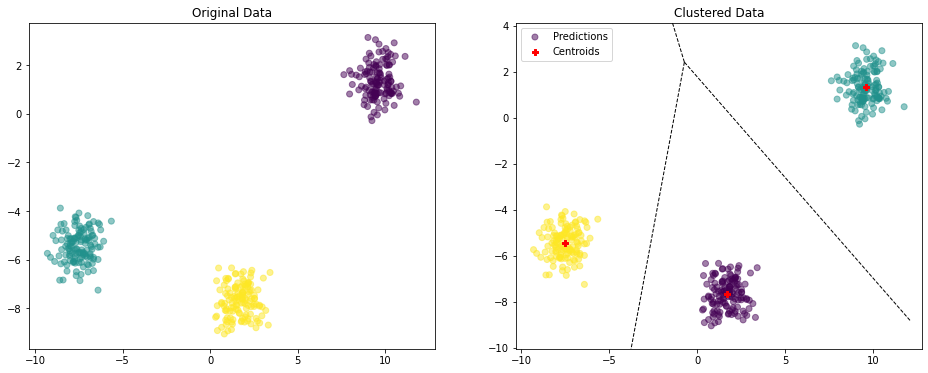

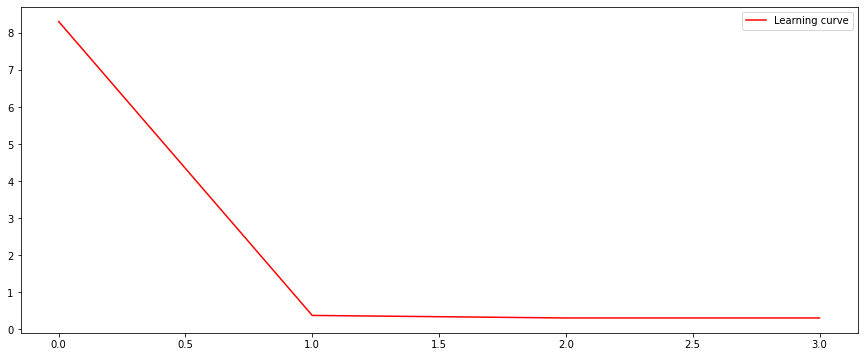


Data set DS 2

run = 0 - iterations = 5 - <E> = 1.8561 
run = 1 - iterations = 6 - <E> = 1.8561 
run = 2 - iterations = 7 - <E> = 1.8561 
run = 3 - iterations = 7 - <E> = 1.8561 
run = 4 - iterations = 16 - <E> = 3.8140 
run = 5 - iterations = 7 - <E> = 1.8558 
run = 6 - iterations = 5 - <E> = 1.8558 
run = 7 - iterations = 16 - <E> = 3.8140 
run = 8 - iterations = 5 - <E> = 1.8561 
run = 9 - iterations = 7 - <E> = 1.8561 

 best run = 5 - <E> = 1.8558
Time for multi-start training (seconds): 2.6761 - runs = 10

Accuracy of the best hard partition using Rand and WTA:  0.9677944862155389
Accuracy of the best hard partition using Jaccard and WTA:  0.9073940616892476


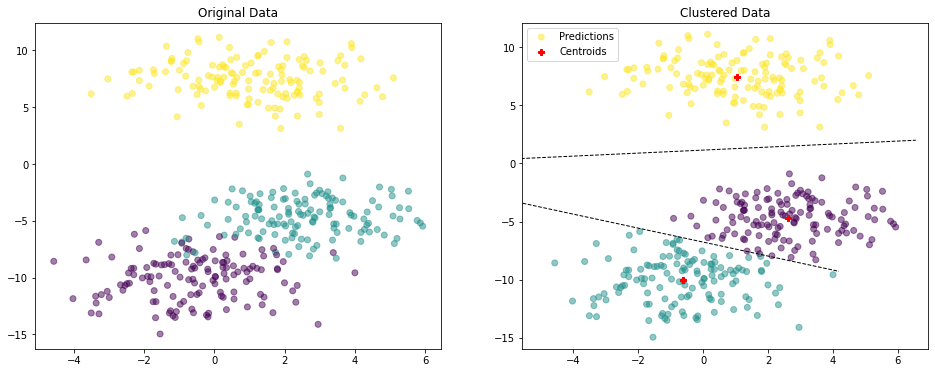

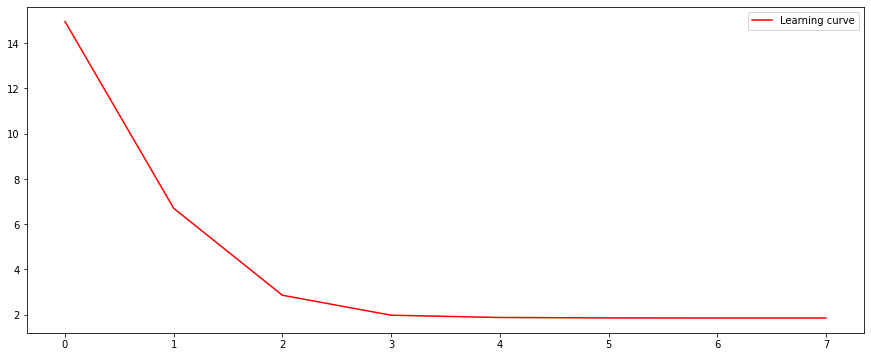


Data set DS 3

run = 0 - iterations = 6 - <E> = 0.0698 
run = 1 - iterations = 8 - <E> = 0.0698 
run = 2 - iterations = 4 - <E> = 0.0698 
run = 3 - iterations = 6 - <E> = 0.0698 
run = 4 - iterations = 5 - <E> = 0.0698 
run = 5 - iterations = 14 - <E> = 0.0698 
run = 6 - iterations = 13 - <E> = 0.0698 
run = 7 - iterations = 14 - <E> = 0.0698 
run = 8 - iterations = 8 - <E> = 0.0698 
run = 9 - iterations = 13 - <E> = 0.0698 

 best run = 0 - <E> = 0.0698
Time for multi-start training (seconds): 1.2056 - runs = 10

Accuracy of the best hard partition using Rand and WTA:  0.9495302013422818
Accuracy of the best hard partition using Jaccard and WTA:  0.8575397827734277


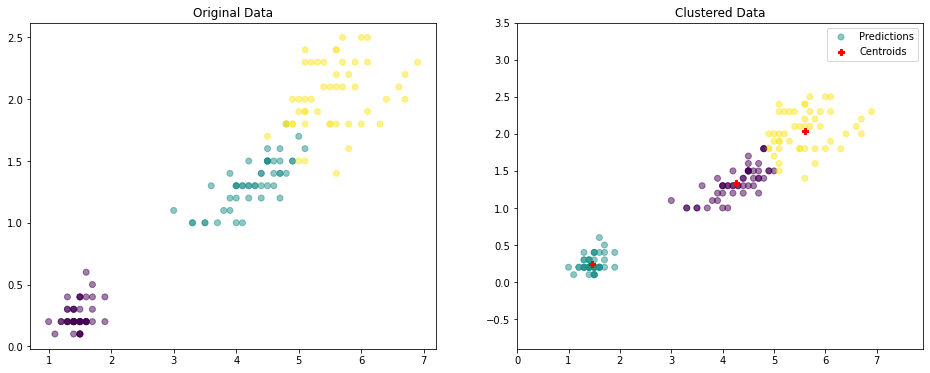

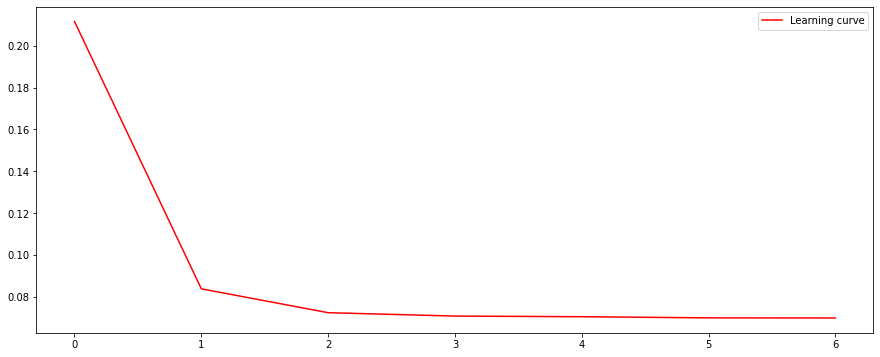

In [28]:
ds_l = [dataset1,dataset2, datasetIris]

count=0
for ds in ds_l:
    count=count+1
    print()
    print("Data set DS",count)
    print()
    x = np.array(ds[x_labels].copy())
    y = np.array(ds[y_label].copy())
    km, E, best_run = multi_start_KMeans(x, num_iter=10)
    c = km.get_centroids()
    U = km.get_U()
    hist = km.get_cost_history()
    p = km.predict(x)
    real_U = Real_U_List[count-1]
    measure_accuracy(real_U, U, alpha=0.4)
    plot_clustered_data(x,y,c,p)
    km.plot_cost_history(data=hist, label="Learning curve")

### 5, 6, 7, 8 -  Experiments with Fuzzy C-Means


In [29]:
def multi_start_CMeans(x, k=3, tau=.0001, num_iter=10):
    # constants assignement
    precision = 4
    E = np.inf

    runs = num_iter  # number of re-starts
    clusters=k
    tau_val=tau
    
    t_before = time.time()    
    for i in range(runs):
        km = CMeans(k=clusters, tau=tau_val, verbose=False)
        km.fit(x)
        EE= km.error
        Niter= km.iteration
        #print("run = {} - <E> = {:.{}f} ".format(i, EE, precision))
        print("run = {} - iterations = {} - <E> = {:.{}f} ".format(i, Niter-1, EE, precision))
        
        if EE < E:
            # store the best instance of trained model
            kmi = km
            E=EE
            best_run=i

    print ('\n best run = {} - <E> = {:.{}f}'.format(best_run, E, precision))
    t_after = time.time()
    ## Compute training time
    t_training = t_after - t_before
    print("Time for multi-start training (seconds): {:.{}f} - runs = {}\n".format(t_training, precision, runs))

    return kmi, E, best_run

In [30]:
# simplified test datasets (for debugging aims)
simpleTest = False
if simpleTest:
    d1a = [[-1.0,-1.0],[-1.1,-1.2],[-1.2,-1.1],[1.0,1.0],[1.1,1.2],[1.2,1.1],[-1.0,1.0],[-1.1,1.2],[-1.2,1.1]]
    target = [0,0,0,1,1,1,2,2,2]
    feats = pd.DataFrame(d1a, columns=x_labels)
    tgts = pd.Series(target, name=y_label)
    dataset1 = pd.concat([feats,tgts],axis=1)
    d2a = [[-0.3,-0.2],[-0.2,-0.25],[-0.35,-0.3],[0.3,0.25],[0.2,0.2],[0.35,0.3],[-0.3,0.2],[-0.35,0.2],[-0.2,0.25],[-0.25,-0.2],[0.3,0.2],[-0.3,0.25]]
    target = [0,0,0,1,1,1,2,2,2,0,1,2]
    feats = pd.DataFrame(d2a, columns=x_labels)
    tgts = pd.Series(target, name=y_label)
    dataset2 = pd.concat([feats,tgts],axis=1)


Data set DS 1

run = 0 - iterations = 8 - <E> = 0.8771 
run = 1 - iterations = 5 - <E> = 0.8771 
run = 2 - iterations = 5 - <E> = 0.8771 
run = 3 - iterations = 7 - <E> = 0.8771 
run = 4 - iterations = 6 - <E> = 0.8771 
run = 5 - iterations = 3 - <E> = 0.8771 
run = 6 - iterations = 5 - <E> = 0.8771 
run = 7 - iterations = 6 - <E> = 0.8771 
run = 8 - iterations = 2 - <E> = 0.8771 
run = 9 - iterations = 5 - <E> = 0.8771 

 best run = 5 - <E> = 0.8771
Time for multi-start training (seconds): 9.7933 - runs = 10

Accuracy of the best hard partition using Rand and WTA:  1.0
Accuracy of the best hard partition using Jaccard and WTA:  1.0


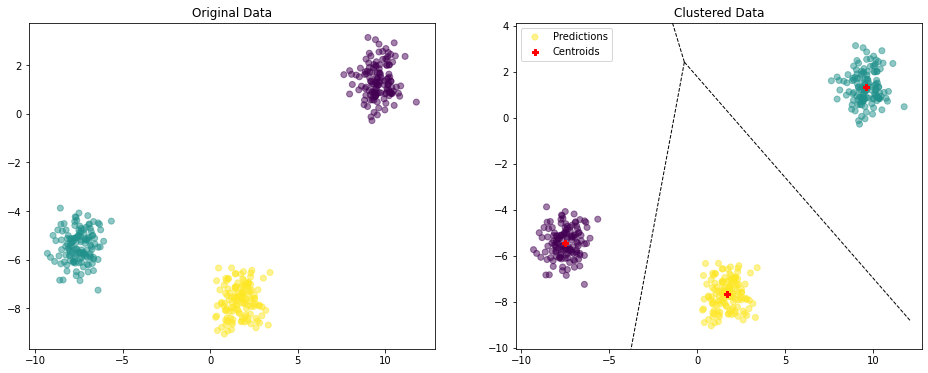

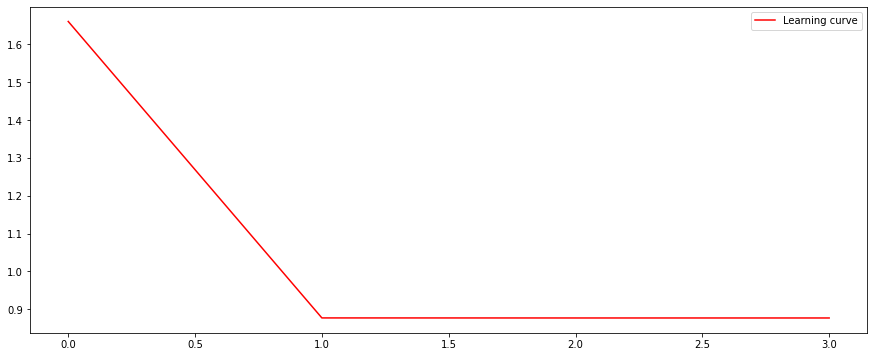


Data set DS 2

run = 0 - iterations = 8 - <E> = 4.6151 
run = 1 - iterations = 8 - <E> = 4.6151 
run = 2 - iterations = 10 - <E> = 4.6151 
run = 3 - iterations = 9 - <E> = 4.6151 
run = 4 - iterations = 15 - <E> = 4.6151 
run = 5 - iterations = 8 - <E> = 4.6151 
run = 6 - iterations = 6 - <E> = 4.6151 
run = 7 - iterations = 7 - <E> = 4.6151 
run = 8 - iterations = 8 - <E> = 4.6151 
run = 9 - iterations = 10 - <E> = 4.6151 

 best run = 5 - <E> = 4.6151
Time for multi-start training (seconds): 15.3513 - runs = 10

Accuracy of the best hard partition using Rand and WTA:  0.9677944862155389
Accuracy of the best hard partition using Jaccard and WTA:  0.9073940616892476


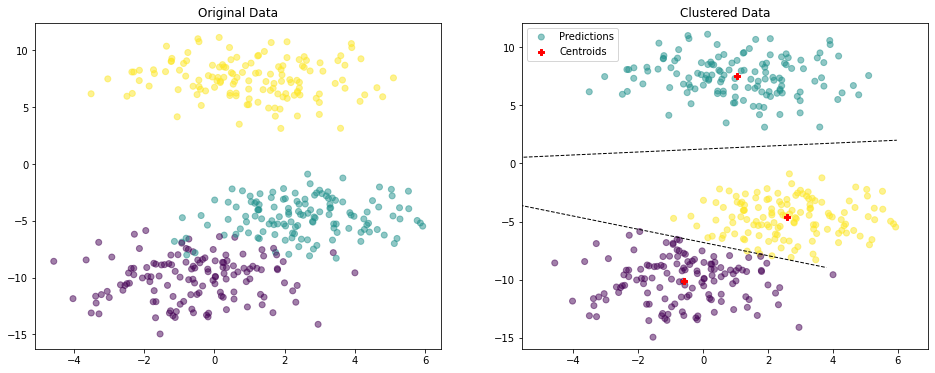

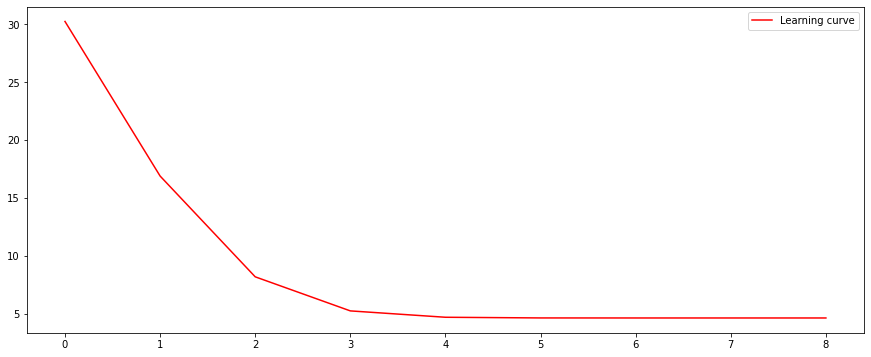


Data set DS 3

run = 0 - iterations = 12 - <E> = 0.1621 
run = 1 - iterations = 8 - <E> = 0.1621 
run = 2 - iterations = 6 - <E> = 0.1621 
run = 3 - iterations = 5 - <E> = 0.1621 
run = 4 - iterations = 5 - <E> = 0.2717 
run = 5 - iterations = 8 - <E> = 0.1621 
run = 6 - iterations = 3 - <E> = 0.2717 
run = 7 - iterations = 5 - <E> = 0.1621 
run = 8 - iterations = 5 - <E> = 0.1621 
run = 9 - iterations = 6 - <E> = 0.1621 

 best run = 9 - <E> = 0.1621
Time for multi-start training (seconds): 10.4287 - runs = 10

Accuracy of the best hard partition using Rand and WTA:  0.9341387024608501
Accuracy of the best hard partition using Jaccard and WTA:  0.8187638512681605


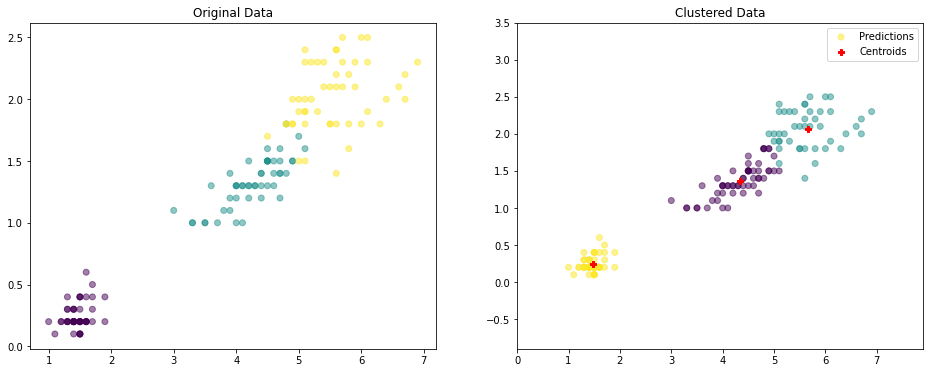

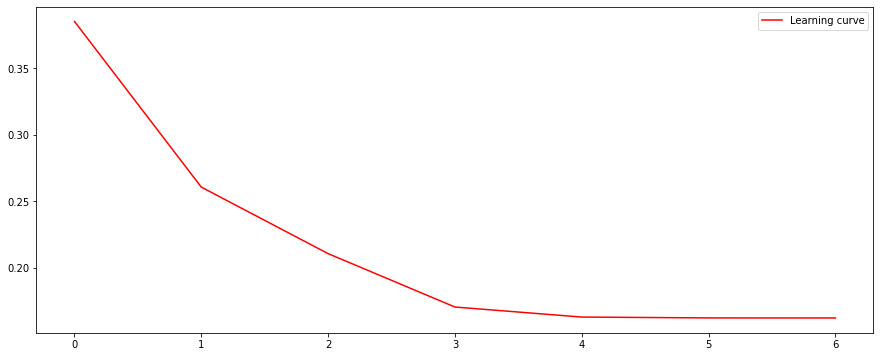

In [31]:
ds_l = [dataset1,dataset2,datasetIris]

count=0
for ds in ds_l:
    count=count+1
    print()
    print("Data set DS",count)
    print()
    x = np.array(ds[x_labels].copy())
    y = np.array(ds[y_label].copy())
    km, E, best_run = multi_start_CMeans(x, num_iter=10)
    c = km.get_centroids()
    U = km.get_U()
    hist = km.get_cost_history()
    p = km.predict(x)
    real_U = Real_U_List[count-1]
    measure_accuracy(real_U, U, alpha=0.4)
    plot_clustered_data(x,y,c,p)
    km.plot_cost_history(data=hist, label="Learning curve")

### 5, 6, 7, 8 - Experiments with  Graded Possibilistic C-Means

In [32]:
def multi_start_GPCMeans(x, devs, k=3, tau=.0001, num_iter=10):
    # constants assignement
    precision = 4
    E = np.inf

    runs = num_iter  # number of re-starts
    clusters=k
    tau_val=tau
    
    t_before = time.time()    
    for i in range(runs):
        km = GPCMeans(k=clusters, eta=devs, tau=tau_val, verbose=False)
        km.fit(x)
        EE= km.error
        Niter= km.iteration
        #print("run = {} - <E> = {:.{}f} ".format(i, EE, precision))
        print("run = {} - iterations = {} - <E> = {:.{}f} ".format(i, Niter-1, EE, precision))
        
        if EE < E:
            # store the best instance of trained model
            kmi = km
            E=EE
            best_run=i

    print ('\n best run = {} - <E> = {:.{}f}'.format(best_run, E, precision))
    t_after = time.time()
    ## Compute training time
    t_training = t_after - t_before
    print("Time for multi-start training (seconds): {:.{}f} - runs = {}\n".format(t_training, precision, runs))

    return kmi, E, best_run

In [33]:
# simplified test datasets (for debugging aims)
simpleTest = False
if simpleTest:
    d1a = [[-1.0,-1.0],[-1.1,-1.2],[-1.2,-1.1],[1.0,1.0],[1.1,1.2],[1.2,1.1],[-1.0,1.0],[-1.1,1.2],[-1.2,1.1]]
    target = [0,0,0,1,1,1,2,2,2]
    feats = pd.DataFrame(d1a, columns=x_labels)
    tgts = pd.Series(target, name=y_label)
    dataset1 = pd.concat([feats,tgts],axis=1)
    d2a = [[-0.3,-0.2],[-0.2,-0.25],[-0.35,-0.3],[0.3,0.25],[0.2,0.2],[0.35,0.3],[-0.3,0.2],[-0.35,0.2],[-0.2,0.25],[-0.25,-0.2],[0.3,0.2],[-0.3,0.25]]
    target = [0,0,0,1,1,1,2,2,2,0,1,2]
    feats = pd.DataFrame(d2a, columns=x_labels)
    tgts = pd.Series(target, name=y_label)
    dataset2 = pd.concat([feats,tgts],axis=1)


Data set DS 1

run = 0 - iterations = 42 - <E> = 15.4328 
run = 1 - iterations = 7 - <E> = 0.3056 
run = 2 - iterations = 20 - <E> = 15.4192 
run = 3 - iterations = 30 - <E> = 0.3391 
run = 4 - iterations = 76 - <E> = 9.5321 
run = 5 - iterations = 30 - <E> = 15.4312 
run = 6 - iterations = 33 - <E> = 25.5090 
run = 7 - iterations = 30 - <E> = 0.3811 
run = 8 - iterations = 23 - <E> = 0.3276 
run = 9 - iterations = 35 - <E> = 0.3823 

 best run = 1 - <E> = 0.3056
Time for multi-start training (seconds): 17.1911 - runs = 10

Accuracy of the best hard partition using Rand and WTA:  1.0
Accuracy of the best hard partition using Jaccard and WTA:  1.0


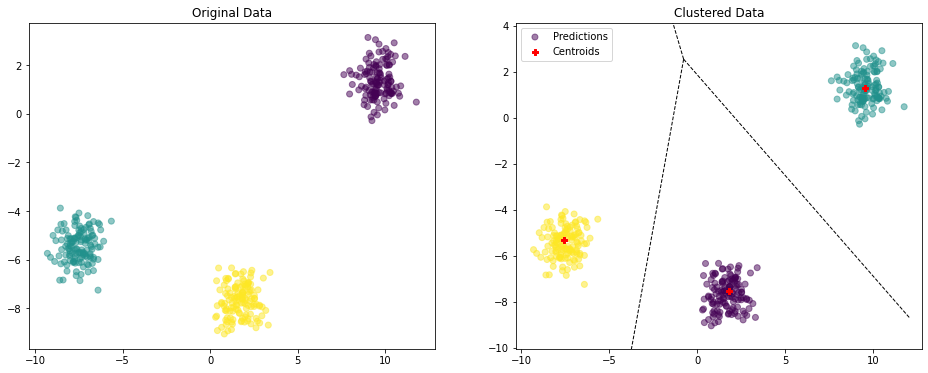

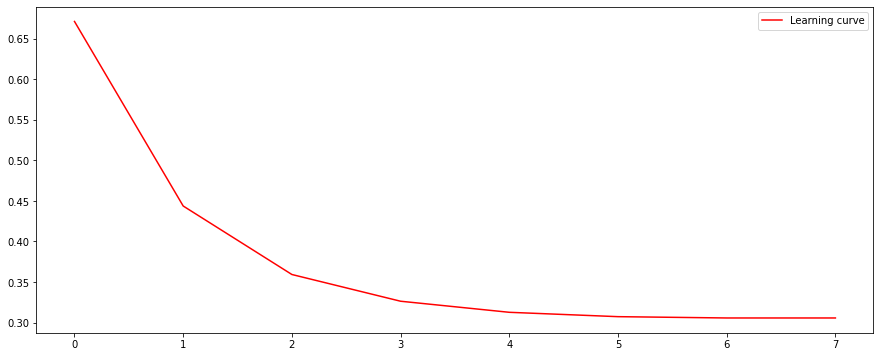


Data set DS 2

run = 0 - iterations = 36 - <E> = 11.6462 
run = 1 - iterations = 29 - <E> = 32.4974 
run = 2 - iterations = 23 - <E> = 20.1612 
run = 3 - iterations = 40 - <E> = 32.3368 
run = 4 - iterations = 32 - <E> = 5.3903 
run = 5 - iterations = 42 - <E> = 4.3792 
run = 6 - iterations = 35 - <E> = 2.1768 
run = 7 - iterations = 39 - <E> = 32.0128 
run = 8 - iterations = 32 - <E> = 3.0286 
run = 9 - iterations = 30 - <E> = 18.0375 

 best run = 6 - <E> = 2.1768
Time for multi-start training (seconds): 18.5707 - runs = 10

Accuracy of the best hard partition using Rand and WTA:  0.7766666666666666
Accuracy of the best hard partition using Jaccard and WTA:  0.5963855421686747


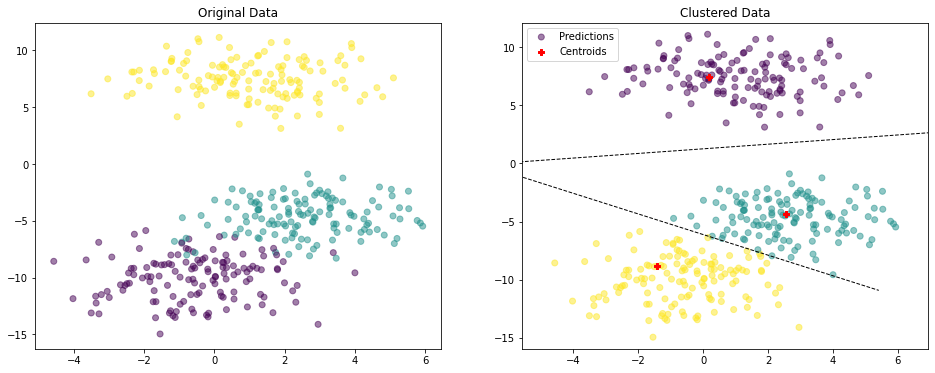

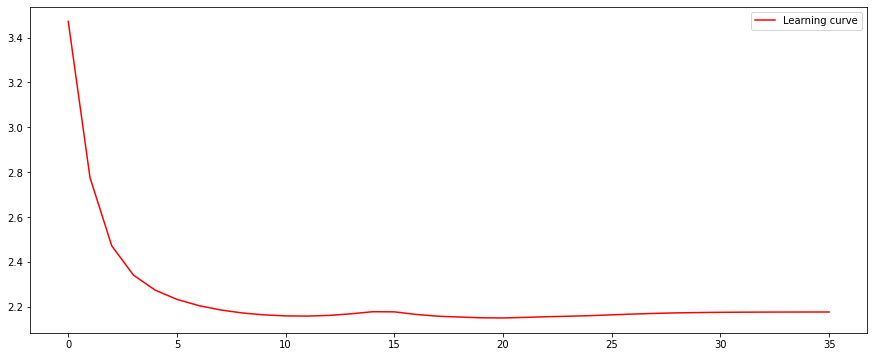


Data set DS 3

run = 0 - iterations = 20 - <E> = 0.0948 
run = 1 - iterations = 6 - <E> = 0.2357 
run = 2 - iterations = 18 - <E> = 1.2758 
run = 3 - iterations = 9 - <E> = 0.0730 
run = 4 - iterations = 19 - <E> = 0.1077 
run = 5 - iterations = 20 - <E> = 0.2106 
run = 6 - iterations = 15 - <E> = 1.2388 
run = 7 - iterations = 14 - <E> = 1.0776 
run = 8 - iterations = 6 - <E> = 0.3744 
run = 9 - iterations = 16 - <E> = 1.1091 

 best run = 3 - <E> = 0.0730
Time for multi-start training (seconds): 3.6159 - runs = 10

Accuracy of the best hard partition using Rand and WTA:  0.8815212527964206
Accuracy of the best hard partition using Jaccard and WTA:  0.6973714285714285


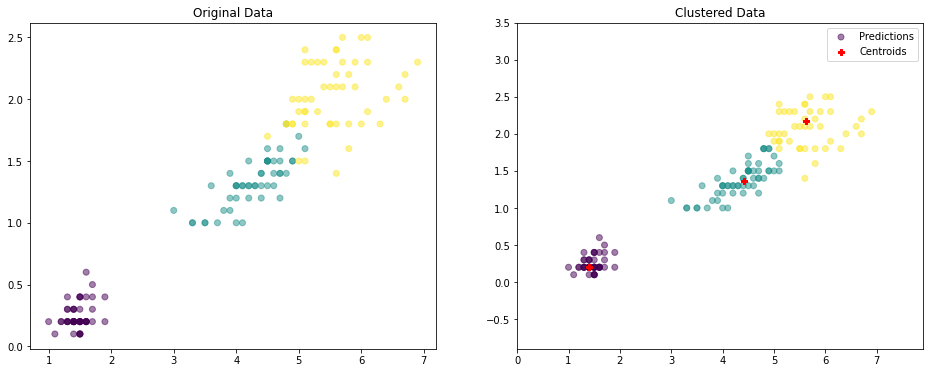

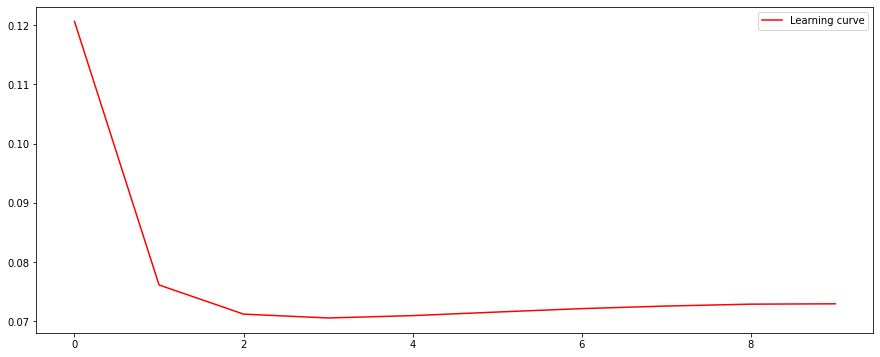

In [34]:
ds_l = [dataset1,dataset2,datasetIris]

count=0
for ds in ds_l:
    count=count+1
    print()
    print("Data set DS",count)
    print()
    x = np.array(ds[x_labels].copy())
    y = np.array(ds[y_label].copy())
    
    if ds.equals(dataset1):
        km, E, best_run = multi_start_GPCMeans(x, devs=[0.7, 0.7, 0.7], num_iter=10)
    elif ds.equals(dataset2):
        km, E, best_run = multi_start_GPCMeans(x, devs=[1.7, 1.7, 1.7], num_iter=10)
    else:
        km, E, best_run = multi_start_GPCMeans(x, devs=[0.5, 0.4, 0.4], num_iter=10)
        
    c = km.get_centroids()
    U = km.get_U()
    hist = km.get_cost_history()
    p = km.predict(x)
    real_U = Real_U_List[count-1]
    measure_accuracy(real_U, U, alpha=0.4)
    plot_clustered_data(x,y,c,p)
    km.plot_cost_history(data=hist, label="Learning curve")

## Optional part
Apply the clustering algorithm you implemented in this notebook to the Semeion handwritten digits database that you can find on the top of the  *CI Homeworks* section. 


NOTE that here the clusters should be 10 or more, as the same digit can be drawn in different ways (graphemes) by different writers.